In [1]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import openmm
import pandas as pd
from mycolorpy import colorlist as mcp
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.stats import linregress
from tools import base, simulator
from tqdm import tqdm

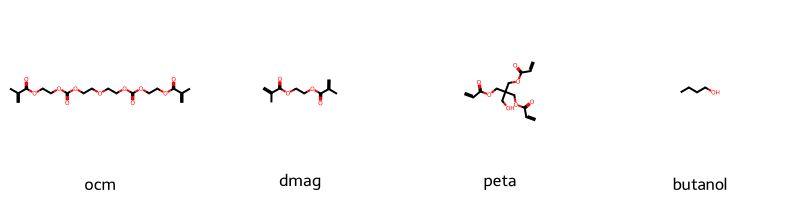

In [2]:
Draw.MolsToGridImage(
    list(base.RD_MOLECULES.values()),
    useSVG=True,
    molsPerRow=4,
    legends=[i.name for i in base.RD_MOLECULES.keys()])

# Collector

In [3]:
%matplotlib inline

In [11]:
def filter_df(df: pd.DataFrame, substance: base.MolNames) -> pd.DataFrame:
    but_time = df[df['BUT'] == df['BUT'].max()]['Time'].max()
    comp_time = df[df[substance.value] == df[substance.value].max()]['Time'].max()

    time_max = min(but_time, comp_time)
    # FIXME:
    time_min = 100*1e-12
    time_max = 1e-4
    # time_max = 100*1e-12
    return df[(time_min <= df['Time']) & (df['Time'] <= time_max)]


def get_data(path: Path):
    substance, x, rho = path.stem.split('_')
    substance = base.MolNames(substance.upper()[:3])
    x = int(x)
    rho = int(rho)
    dfs = []
    for file in os.listdir(path):
        file=path/Path(file)
        T = int(file.stem)
        df = pd.read_csv(file, index_col=0)
        if 'BUT' not in df.columns:
            df['BUT'] = 0
        df = filter_df(df, substance)

        df['MSD substance'] = df[substance.value]
        df['MSD butanol'] = df['BUT']
        df['T'] = T
        dfs.append(df)

    df = pd.concat(dfs,ignore_index=True)
    df['substance'] = substance.value
    df['rho'] = rho
    df['x'] = x
    return df.drop(columns=[substance.value, 'BUT'])[[
        'Time','substance','T','x','rho','MSD substance','MSD butanol'
    ]]


def collect():
    dfs = []
    for current_dir in os.listdir('results'):
        dfs.append(get_data(Path(f'results/{current_dir}')))
    return pd.concat(dfs)


def get_D(time, mse):
    try:
        linear_model = linregress(time, mse)
        slope = linear_model.slope
        D_comp = slope / 6 * 24 * 60 * 60
    except:
        D_comp = 0
    return D_comp


def extract_D(df_all):
    data = []
    for (substance, x, T), df in df_all.groupby(by=['substance', 'x', 'T']):
        D_substance = get_D(df['Time'], df['MSD substance'])
        D_butanol = get_D(df['Time'], df['MSD butanol'])
        data.append(
            {
                'substance': substance,
                'x': x,
                'T': T,
                'D_substance': D_substance,
                'D_butanol': D_butanol,
            }
        )
    return pd.DataFrame(data)

In [12]:
DF = collect()

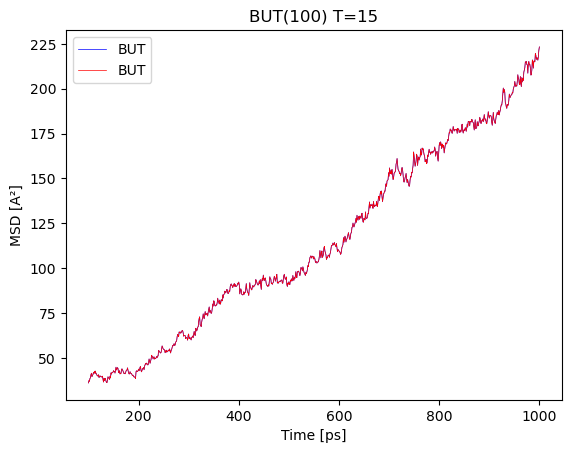

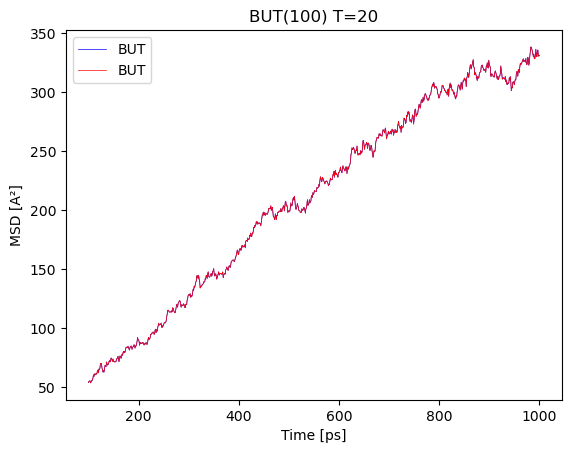

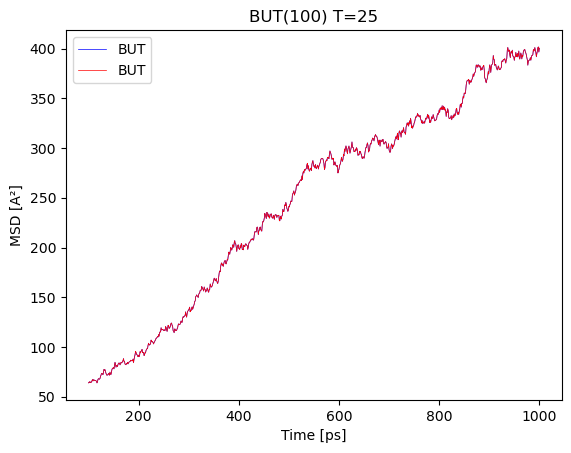

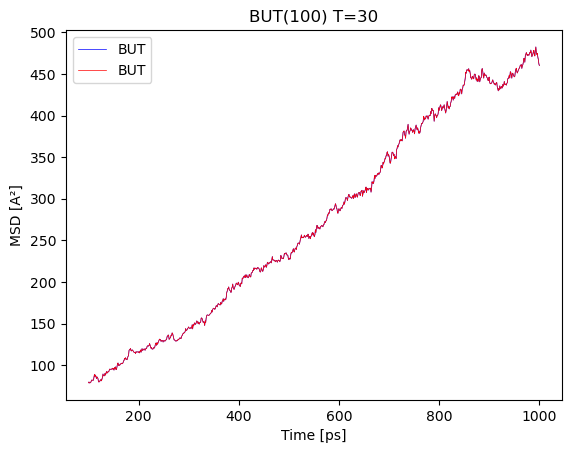

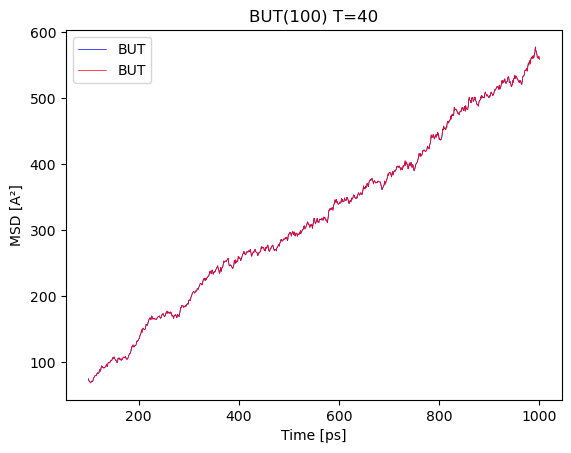

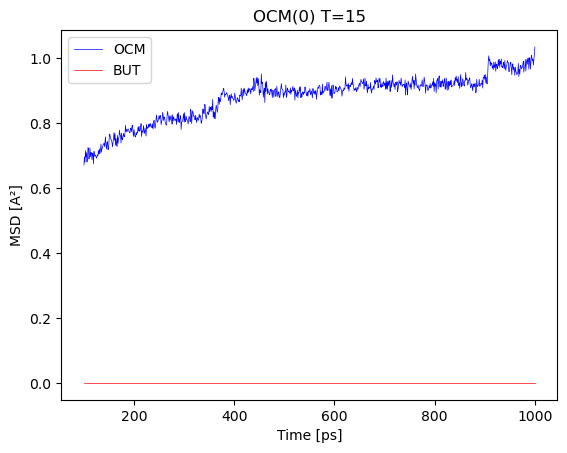

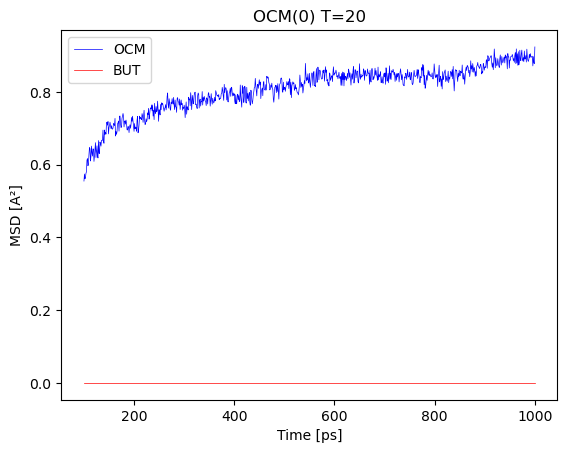

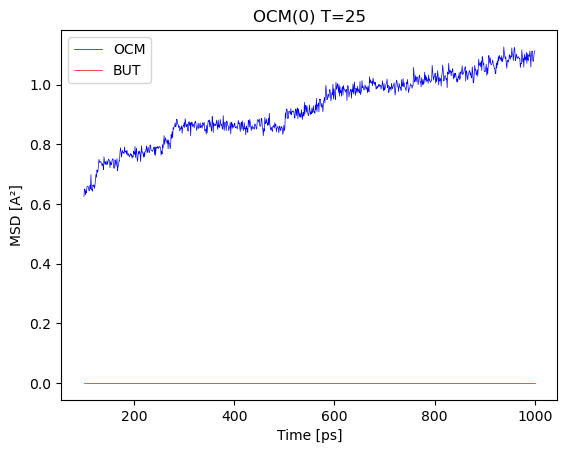

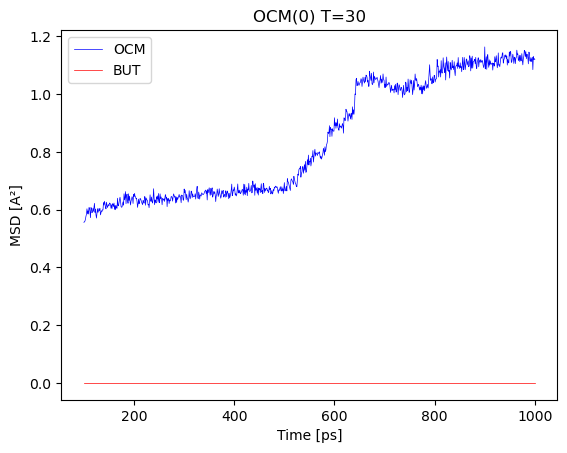

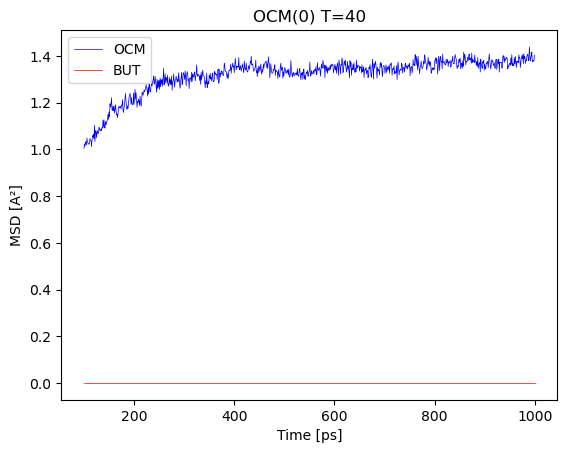

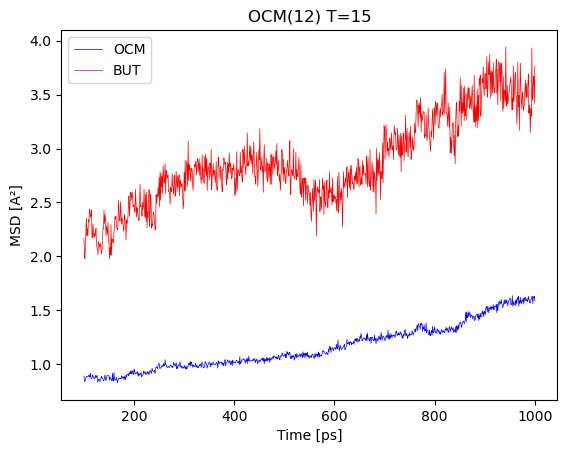

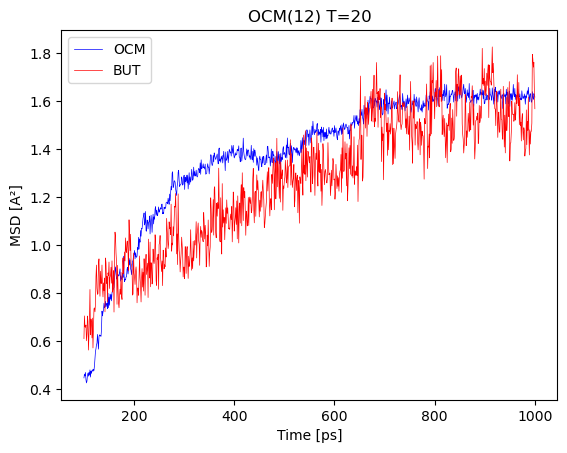

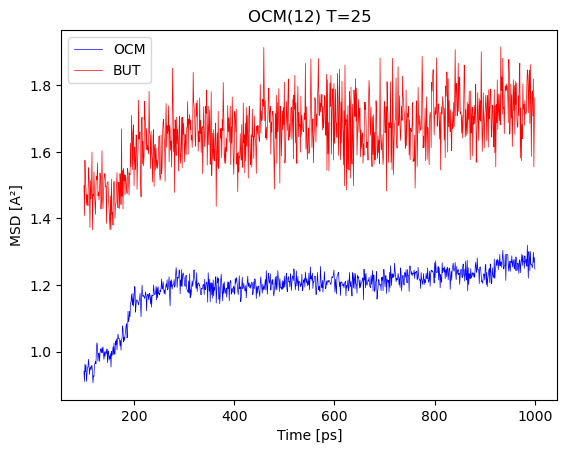

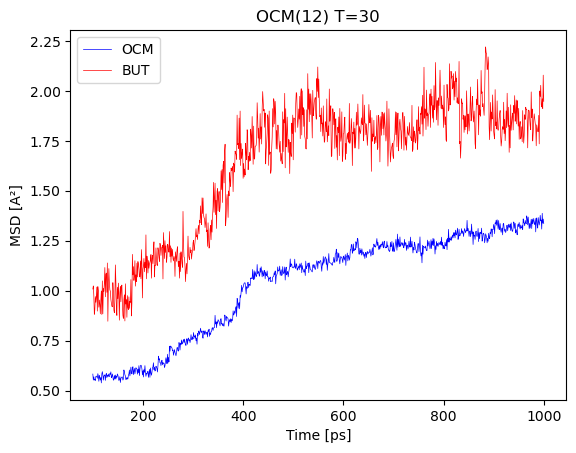

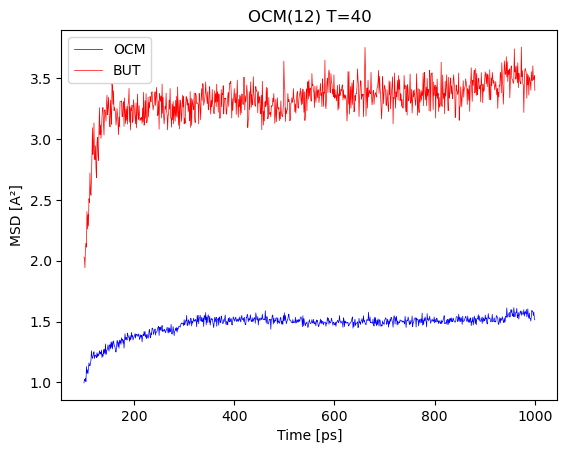

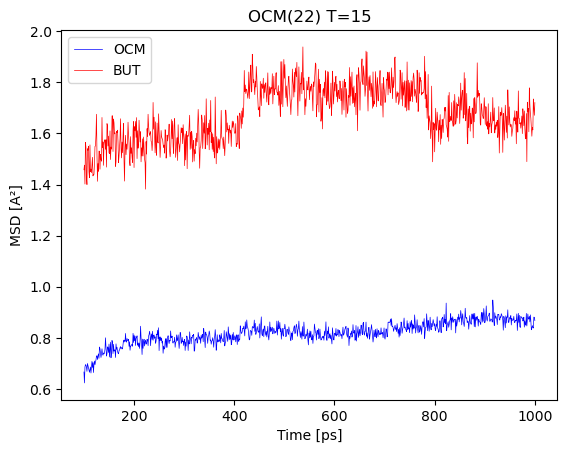

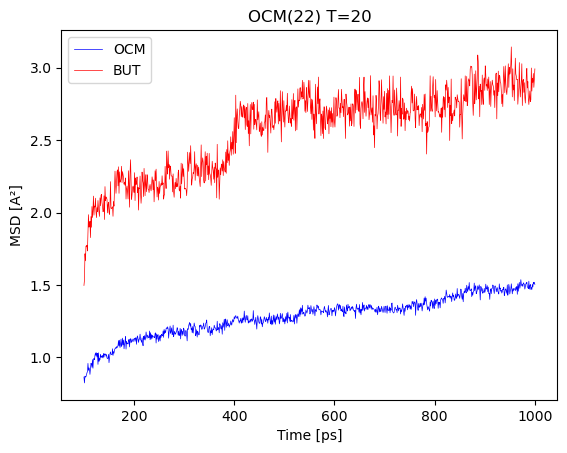

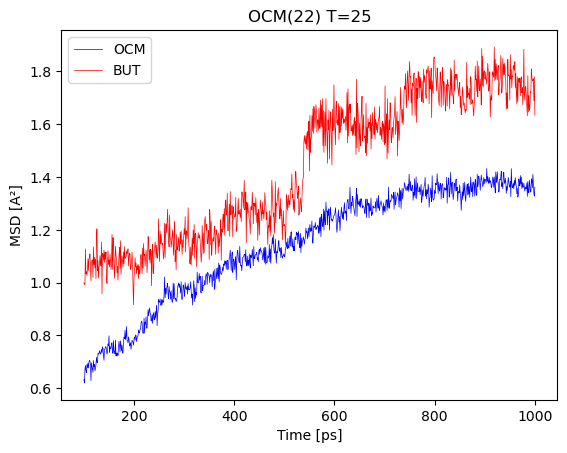

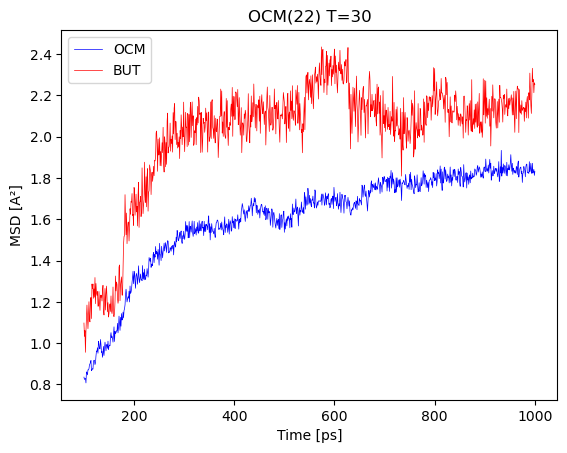

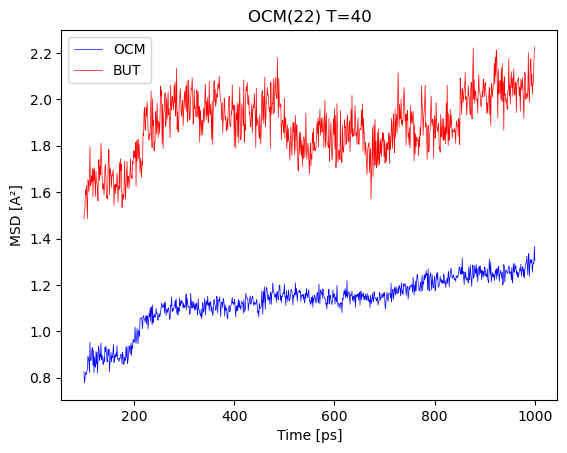

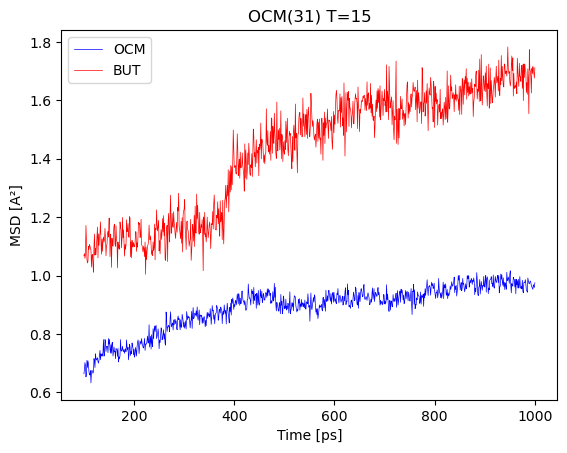

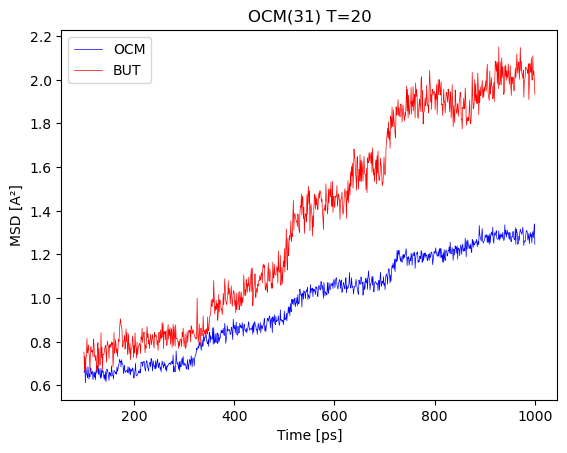

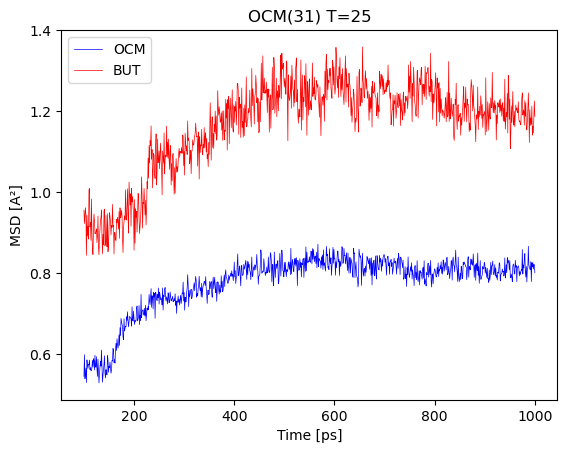

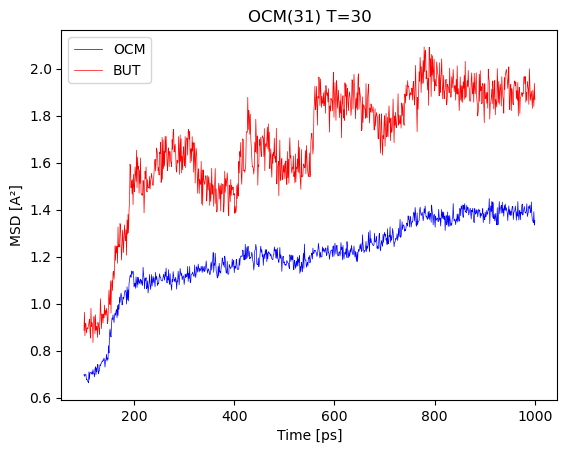

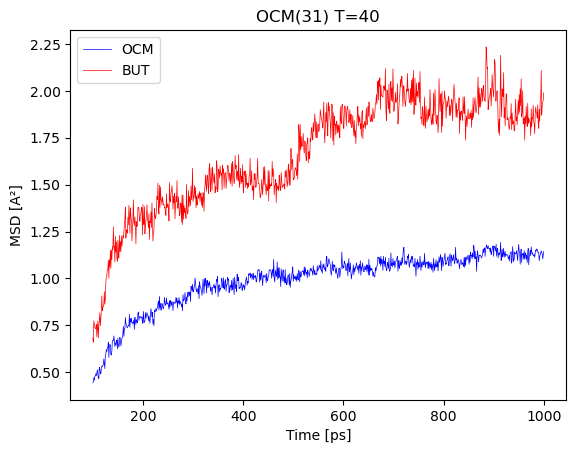

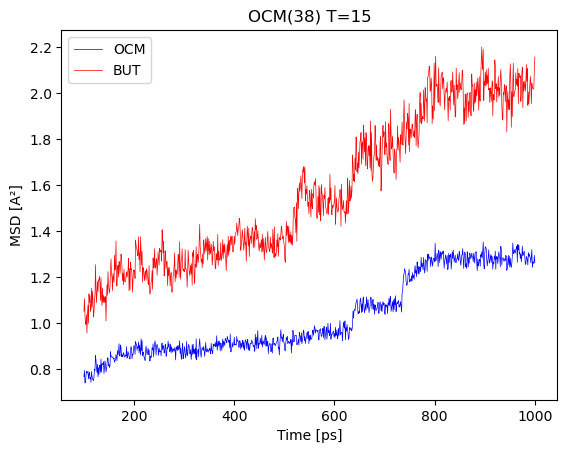

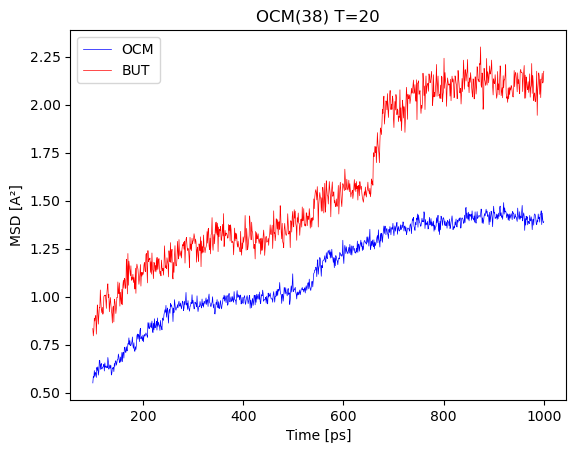

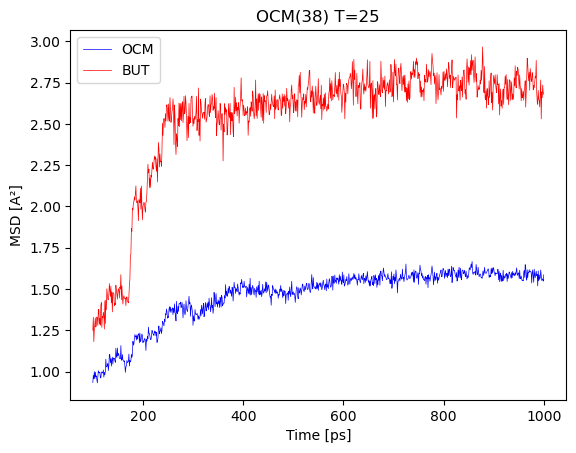

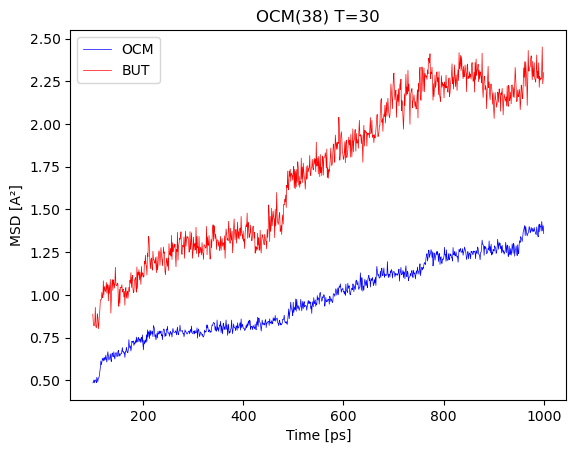

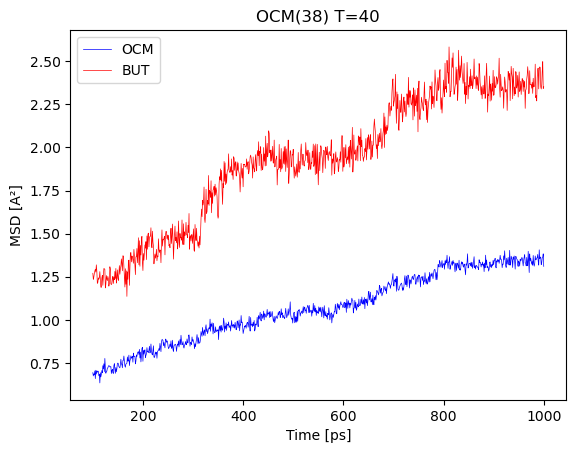

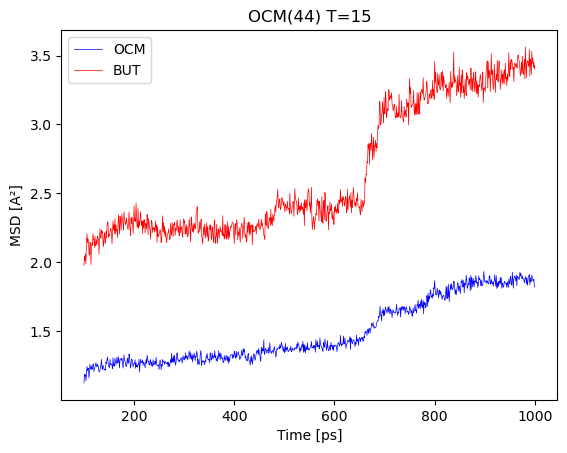

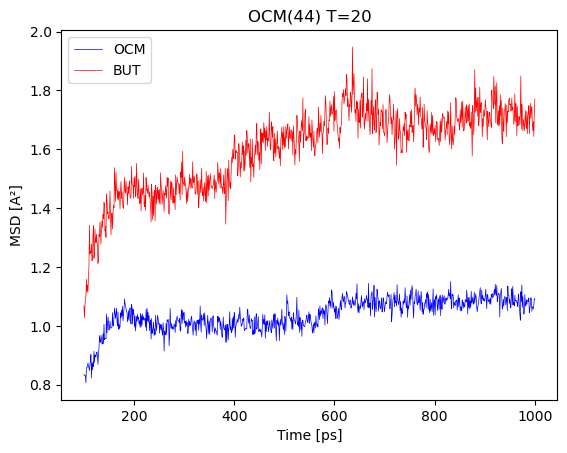

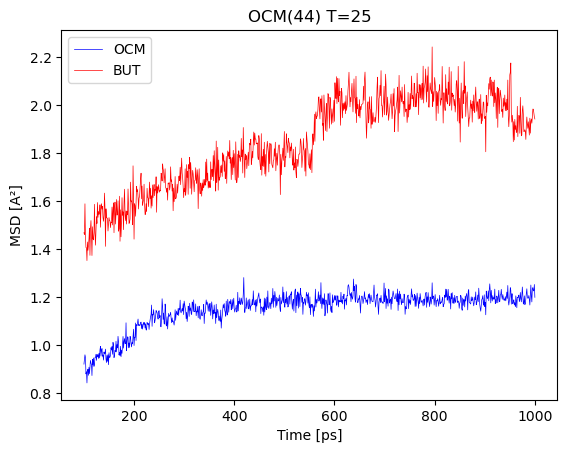

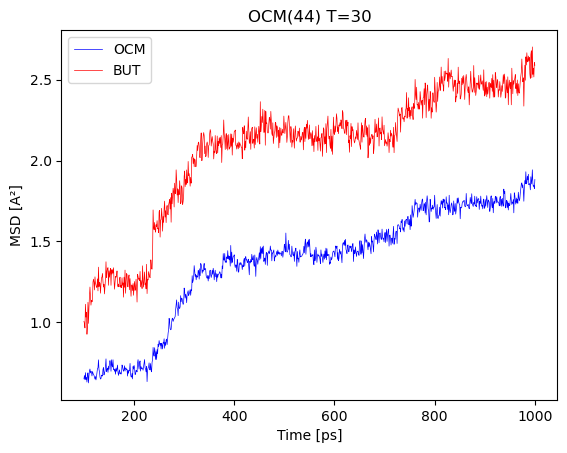

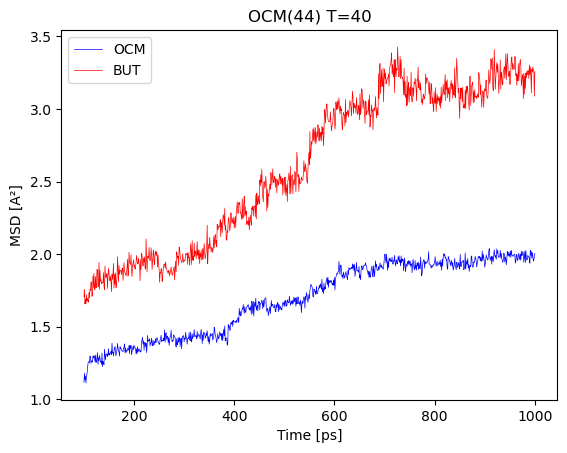

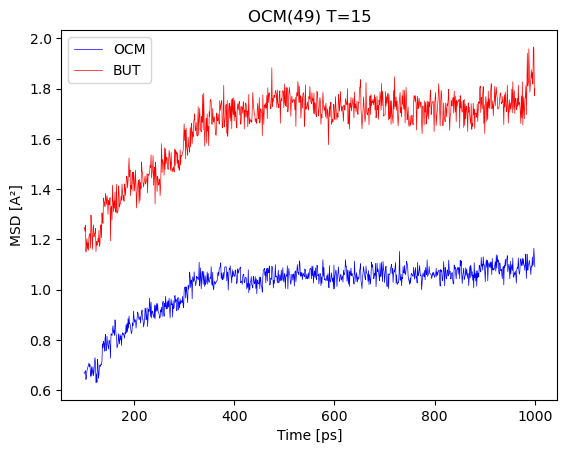

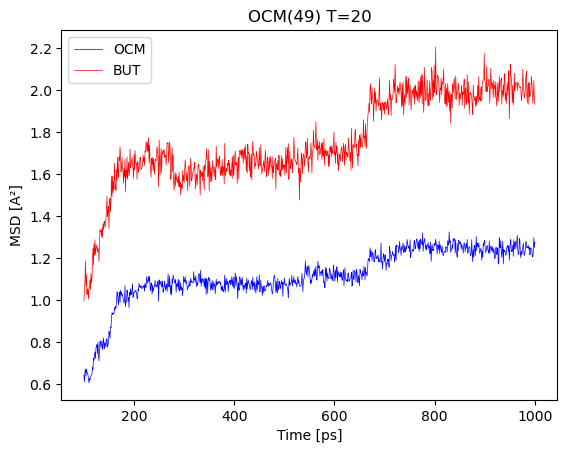

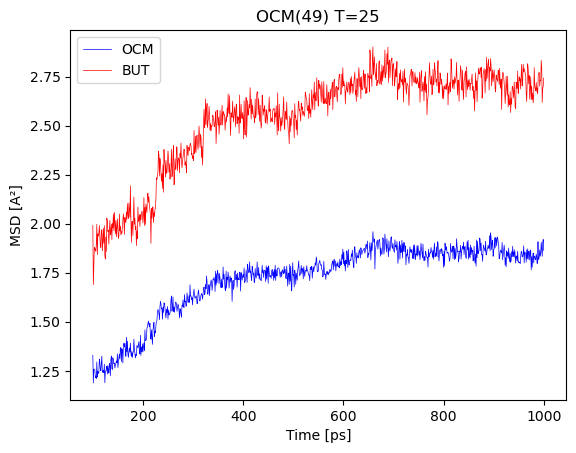

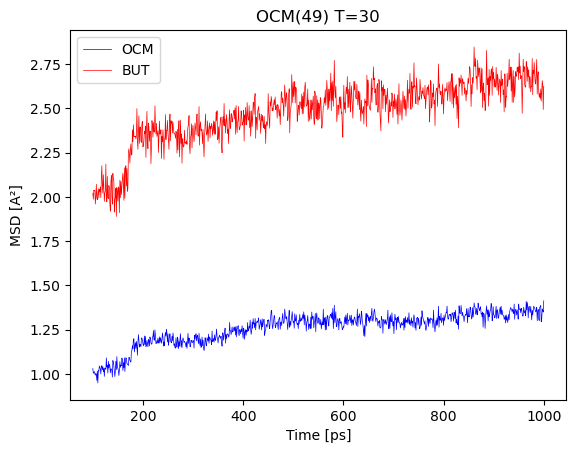

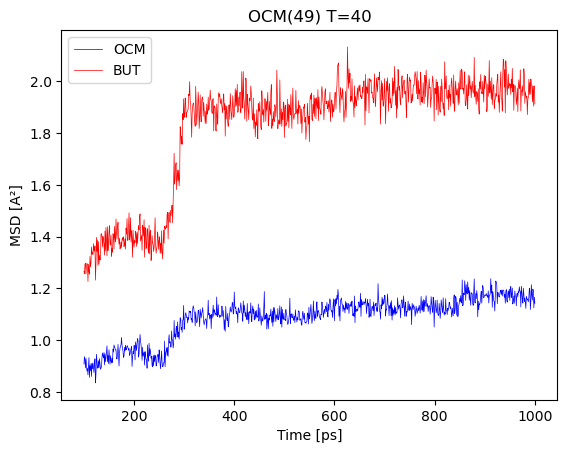

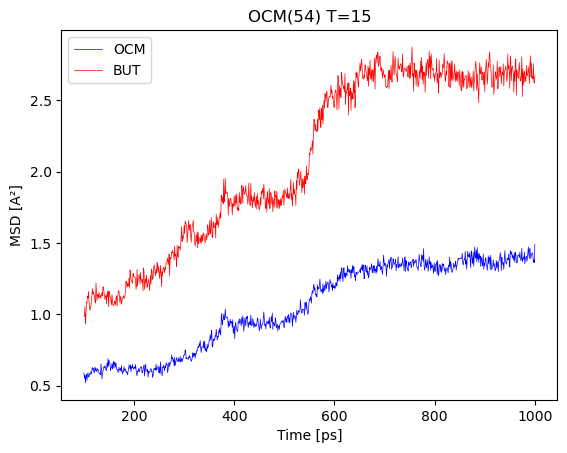

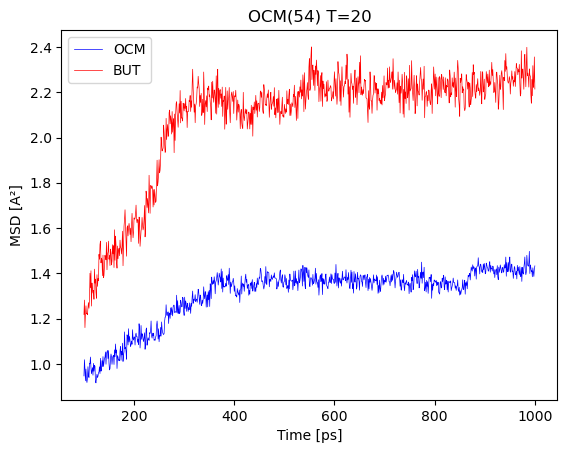

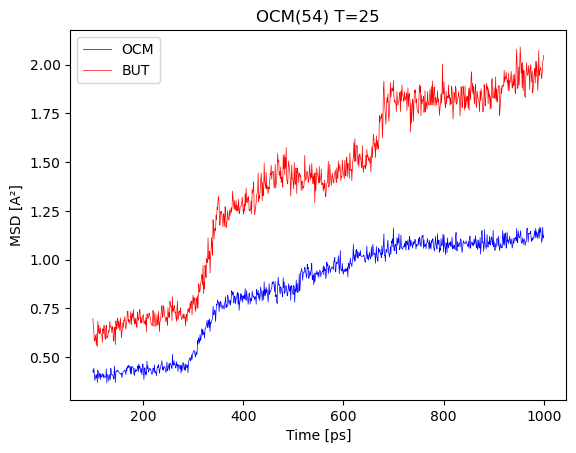

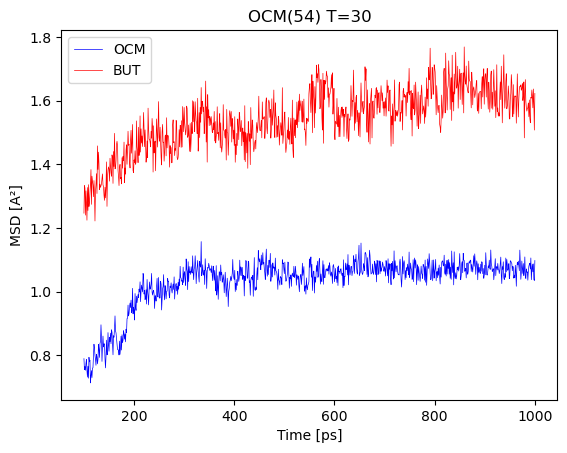

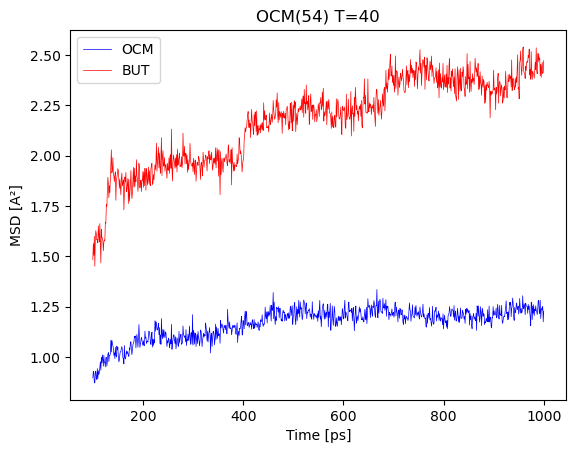

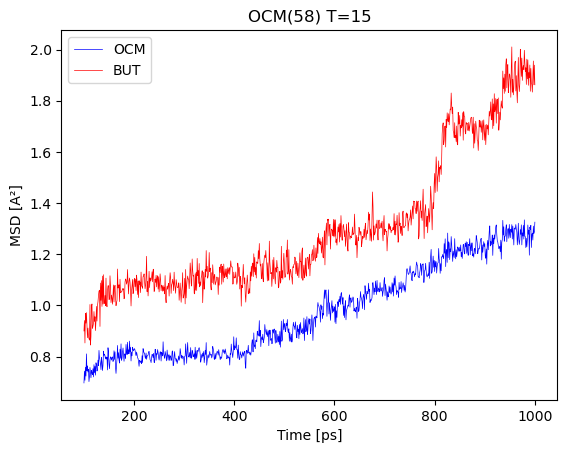

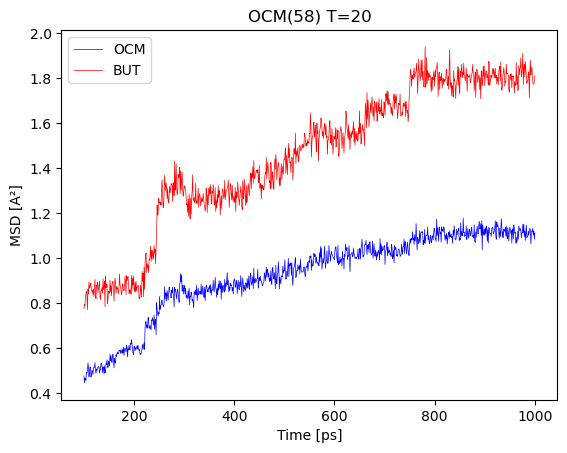

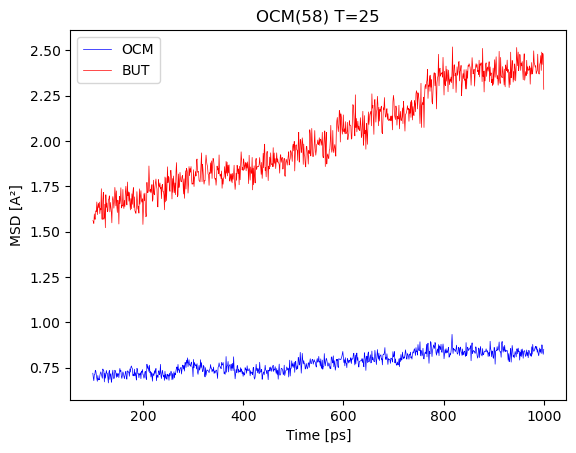

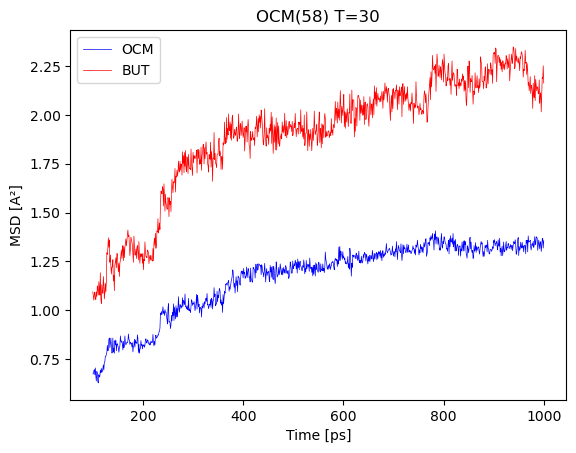

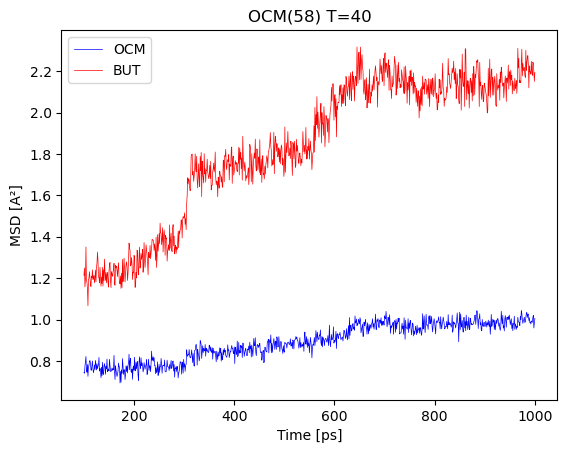

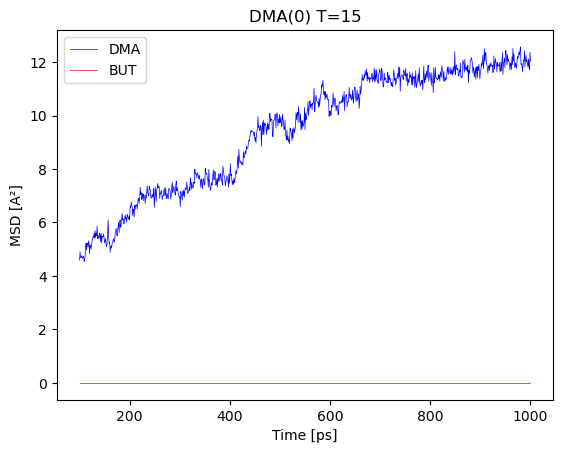

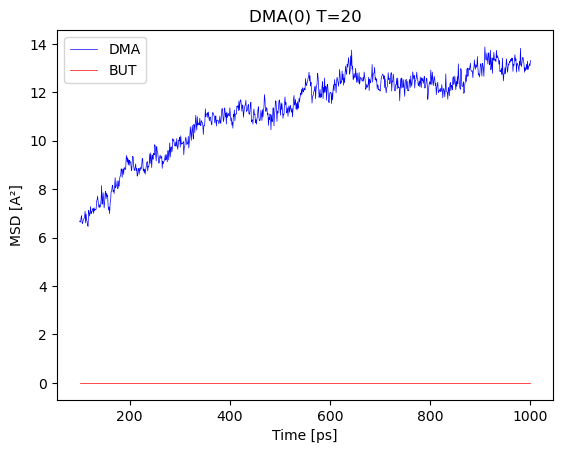

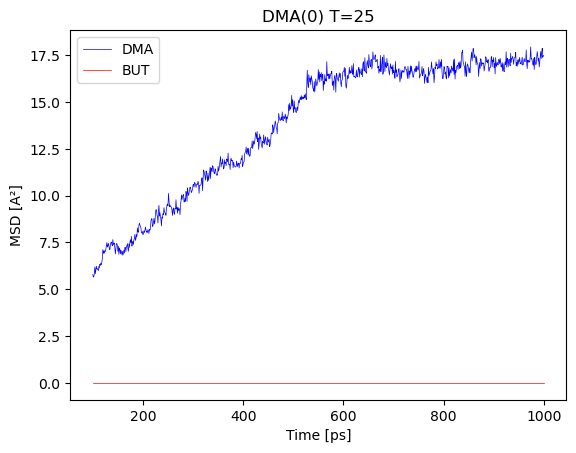

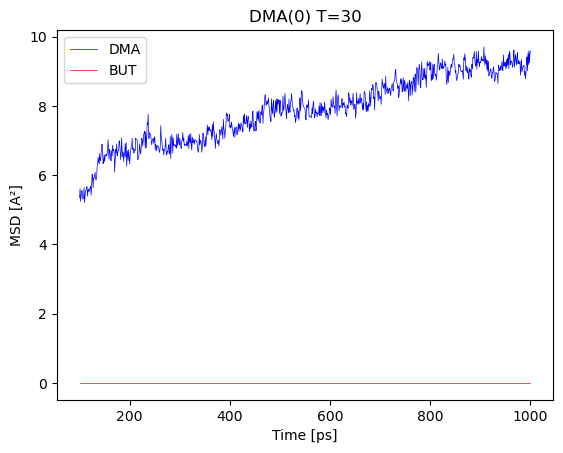

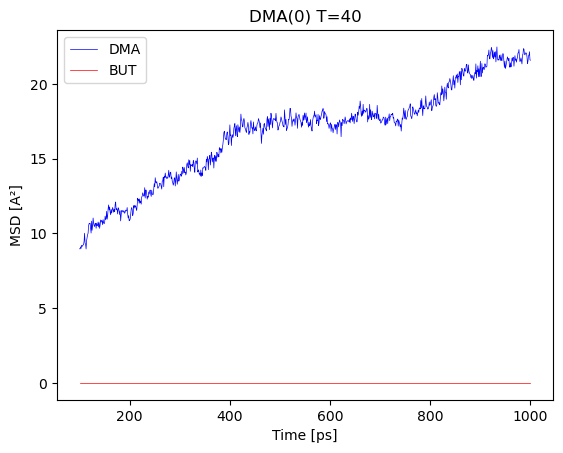

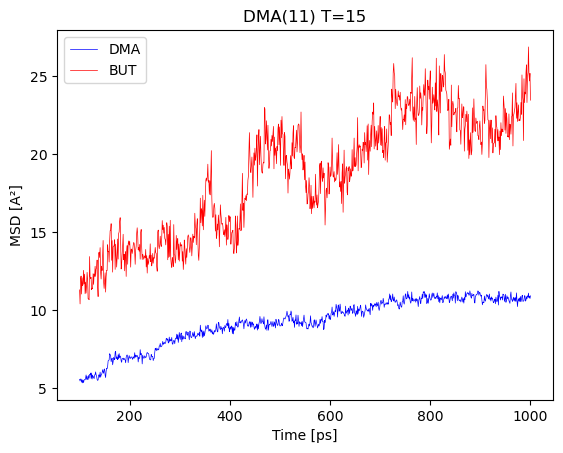

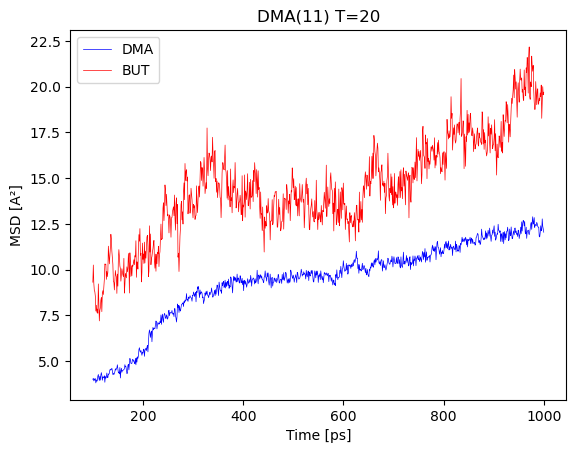

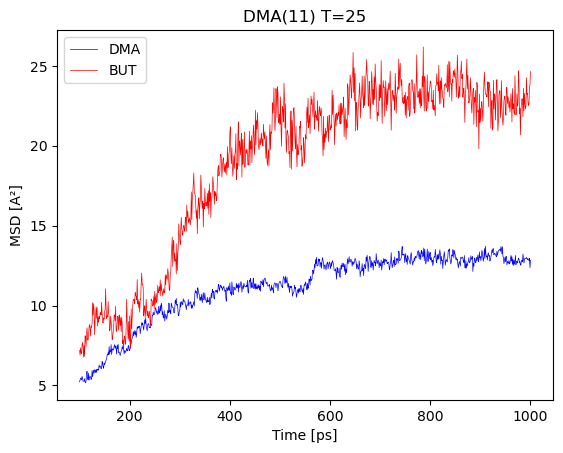

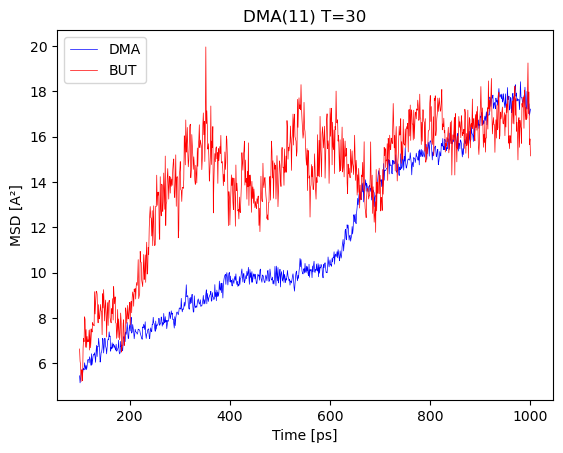

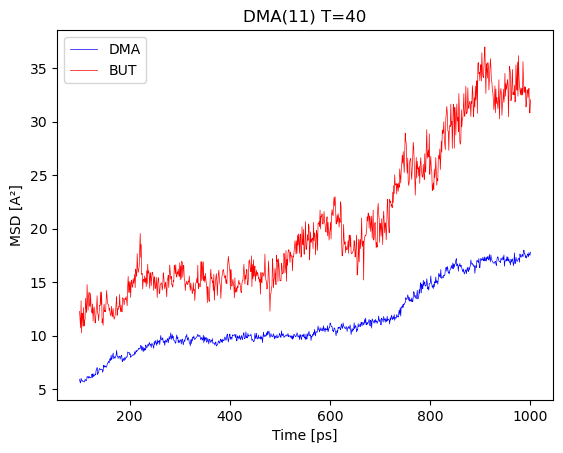

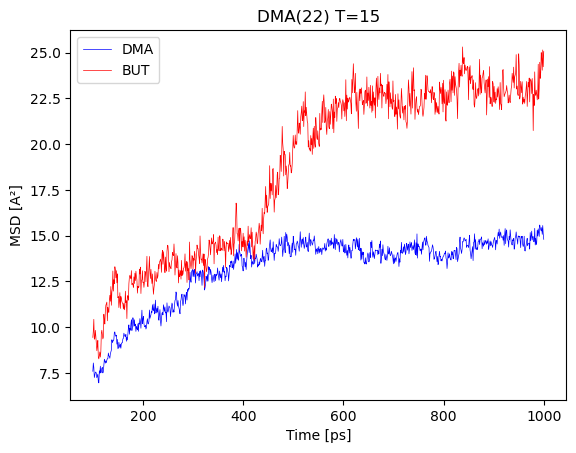

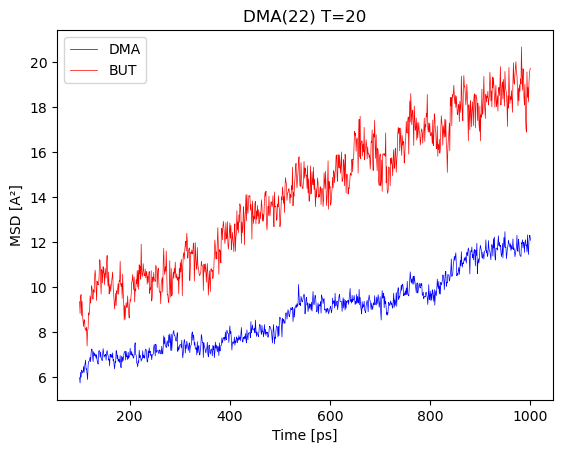

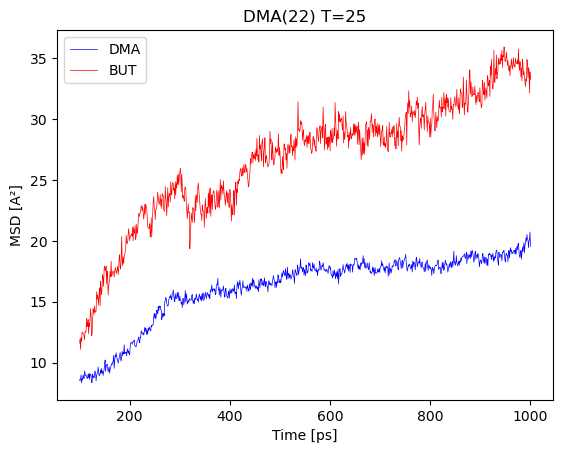

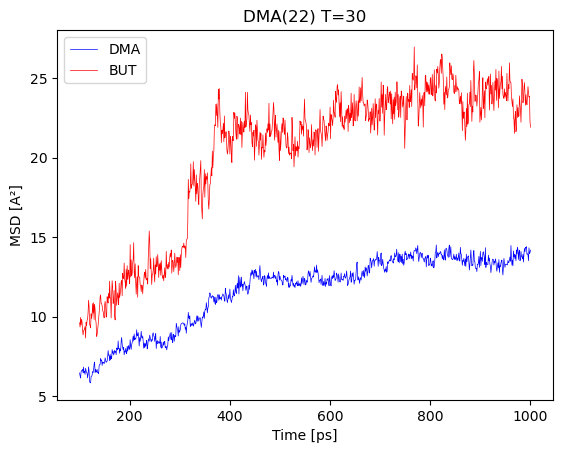

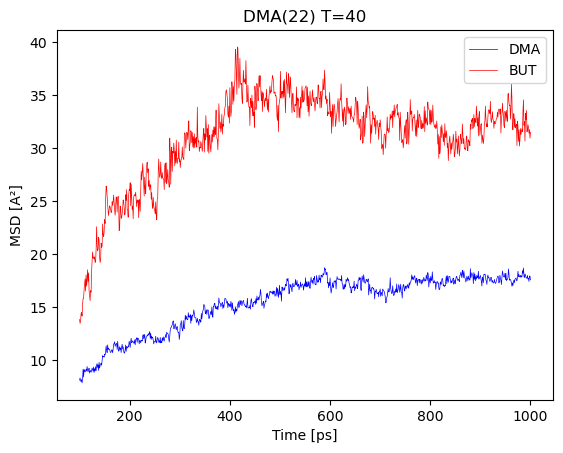

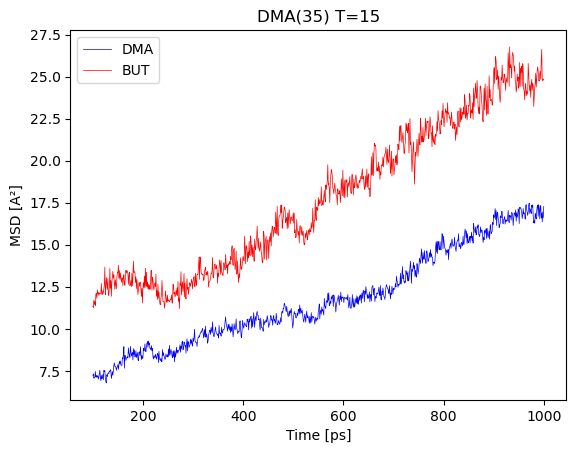

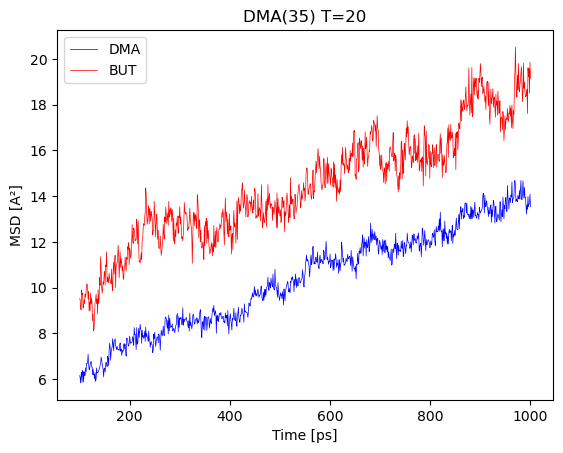

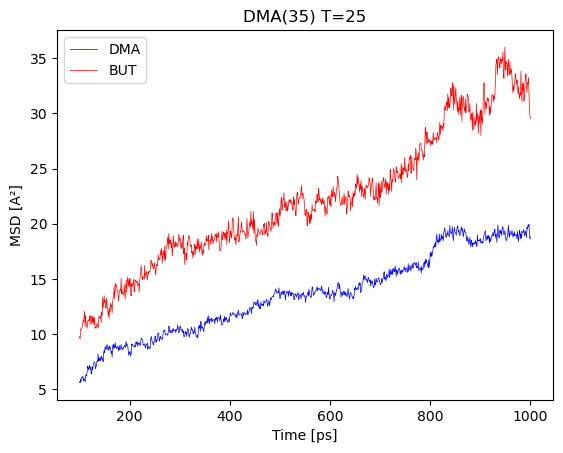

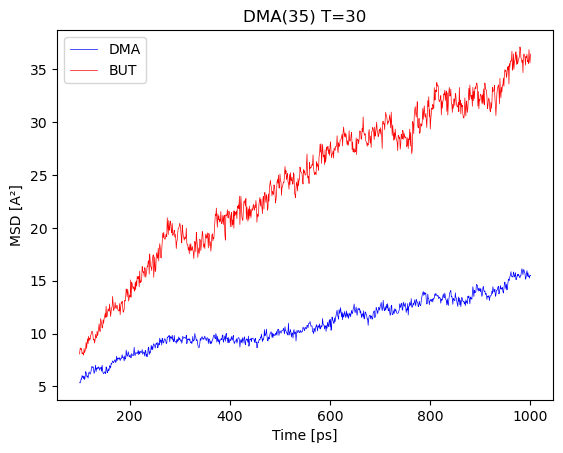

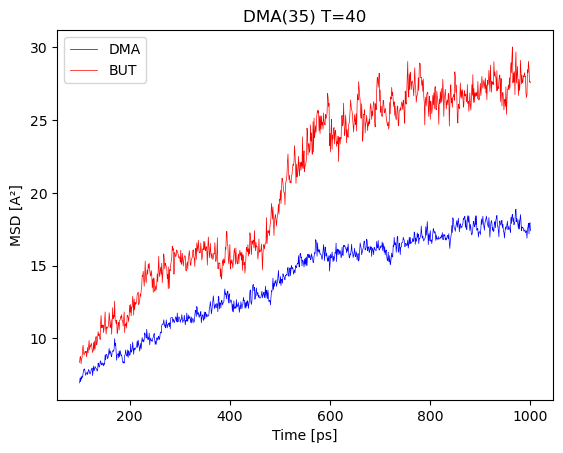

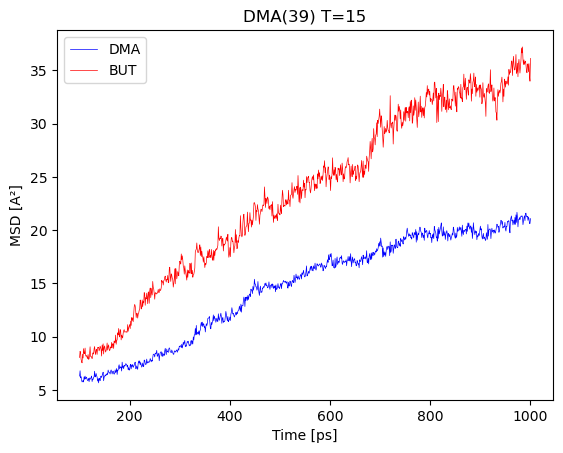

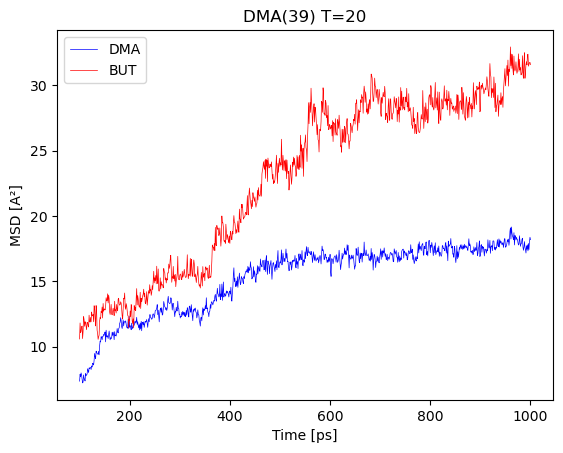

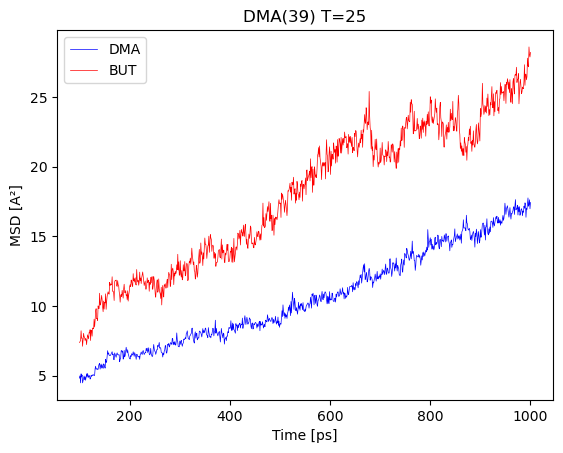

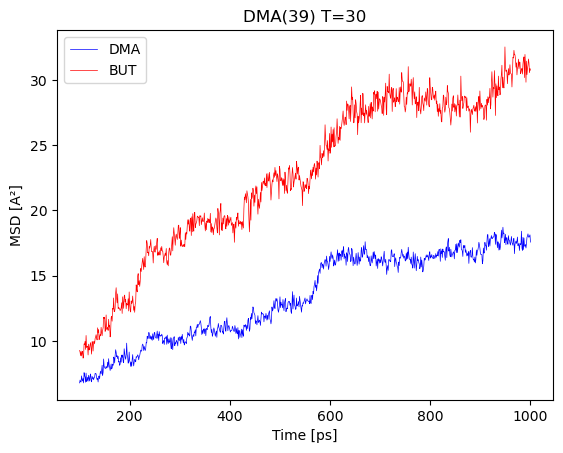

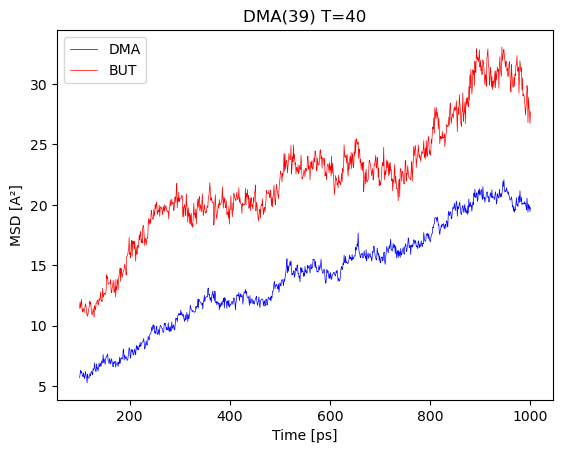

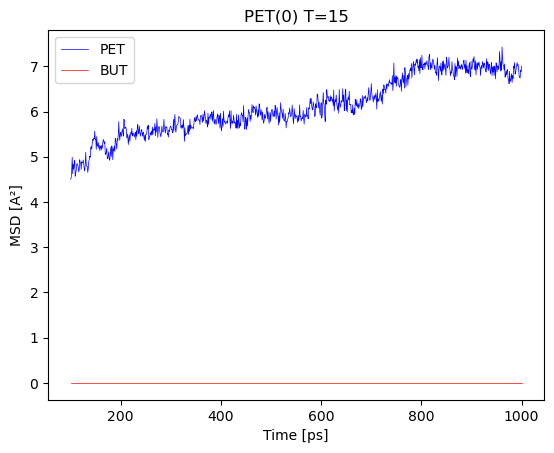

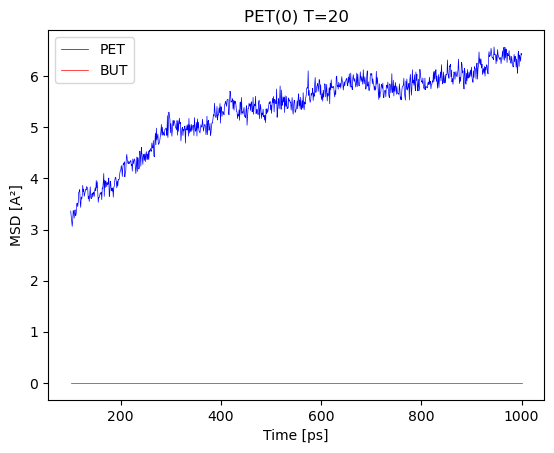

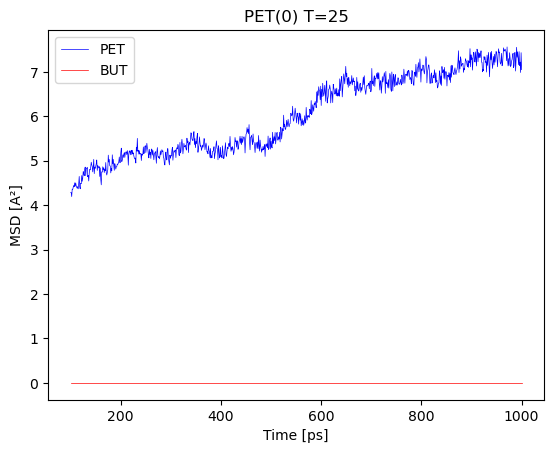

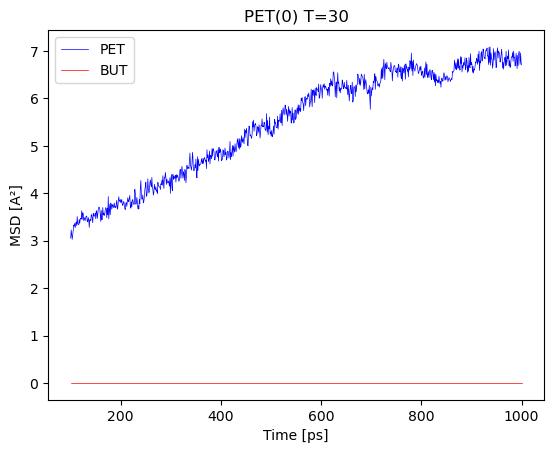

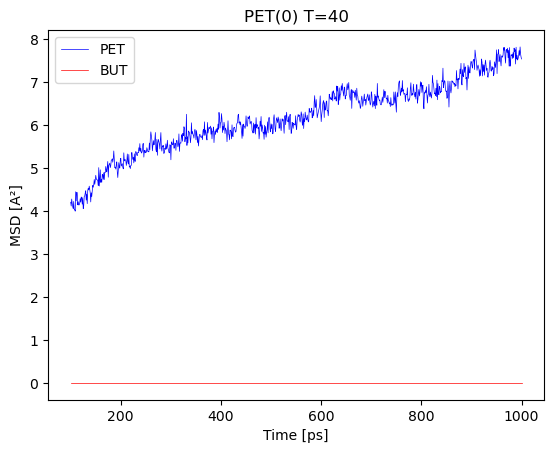

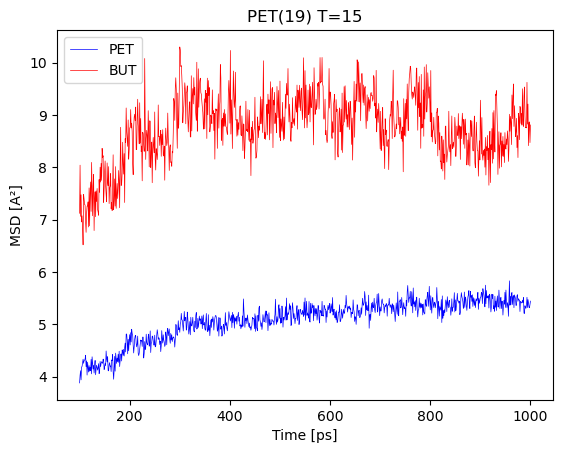

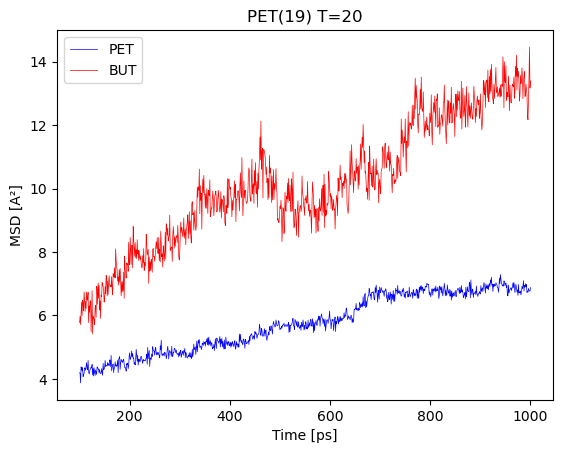

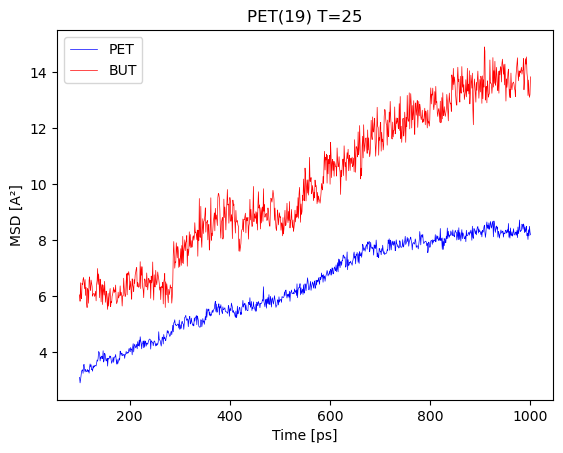

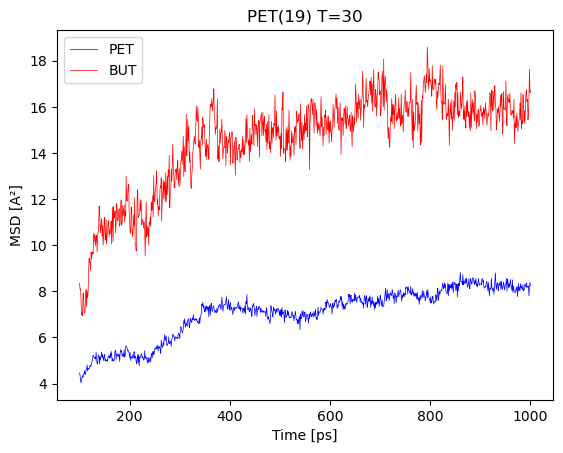

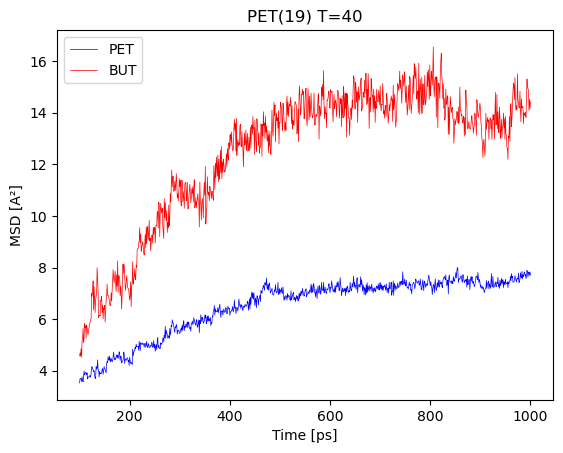

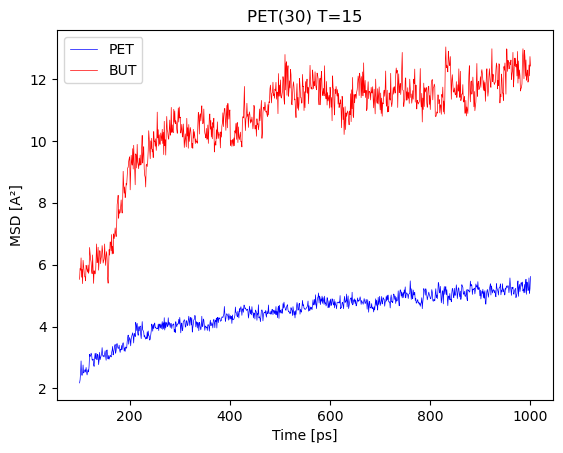

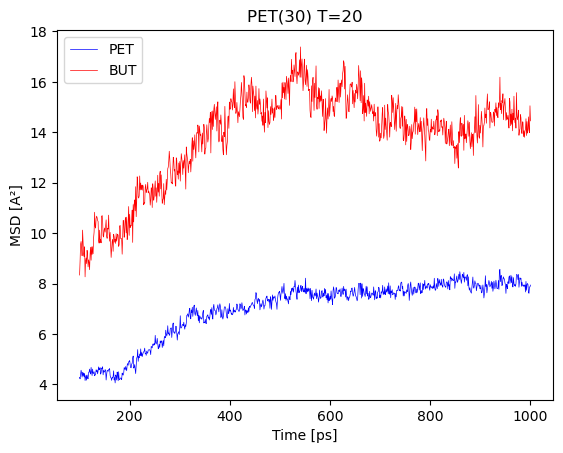

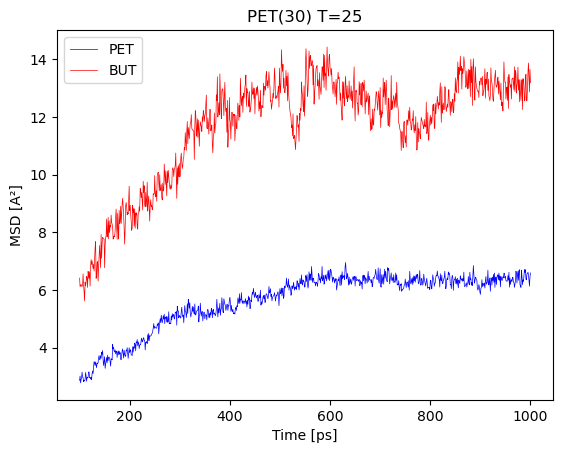

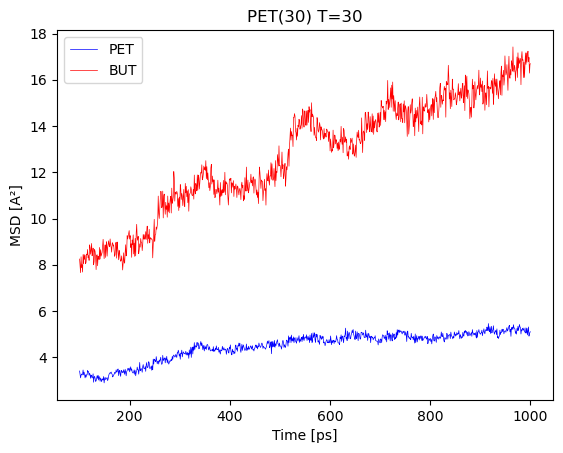

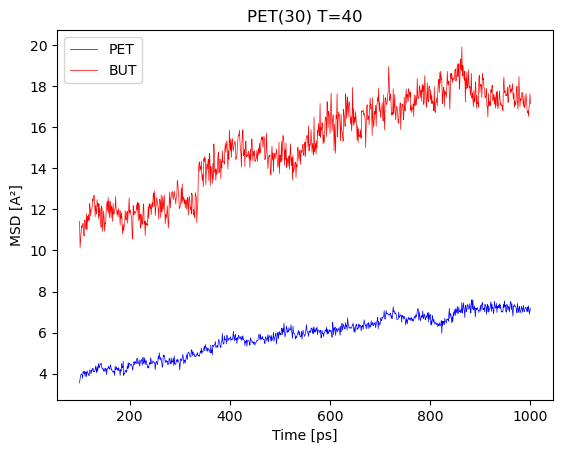

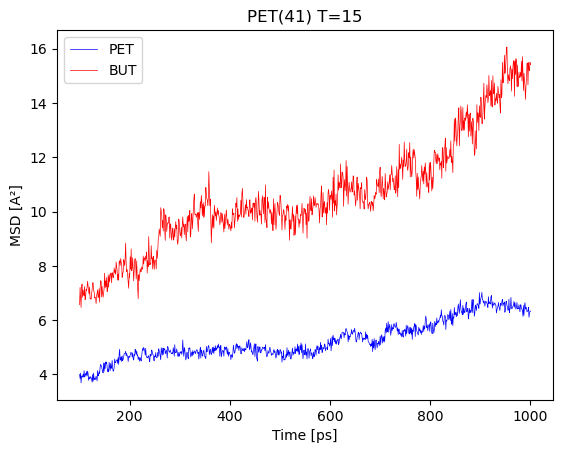

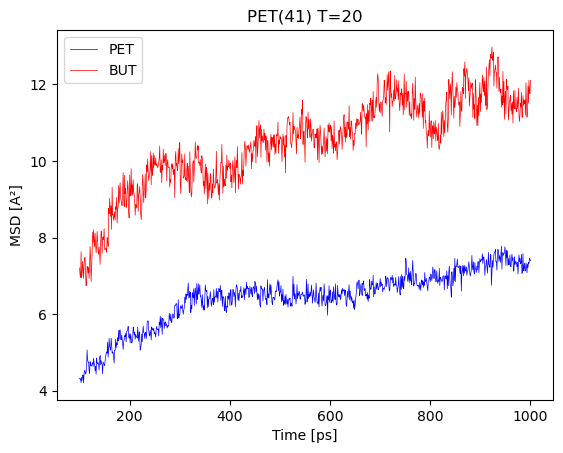

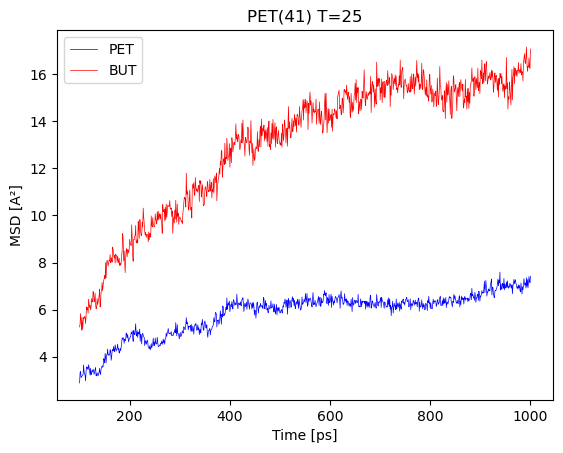

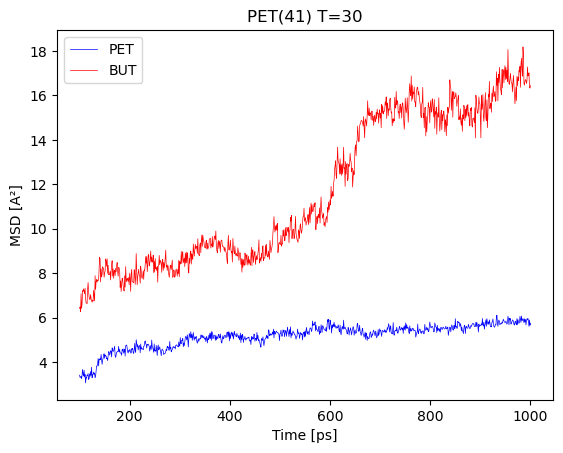

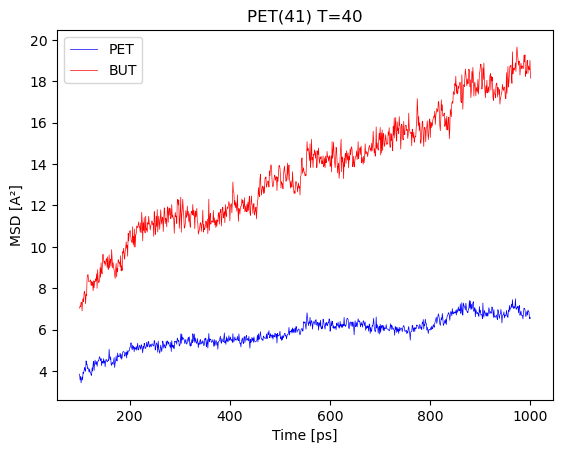

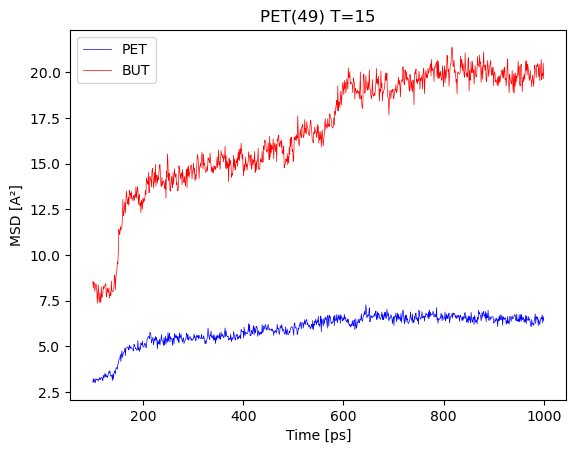

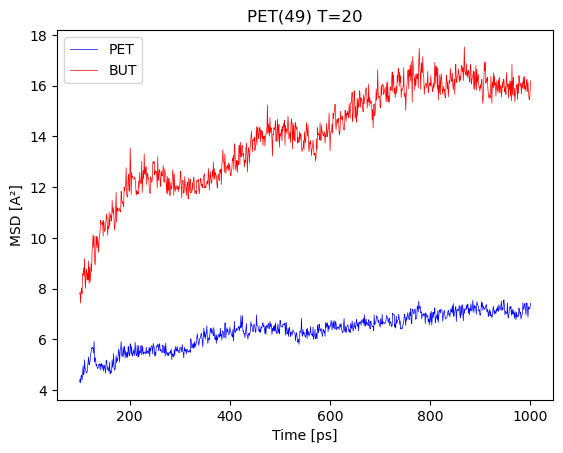

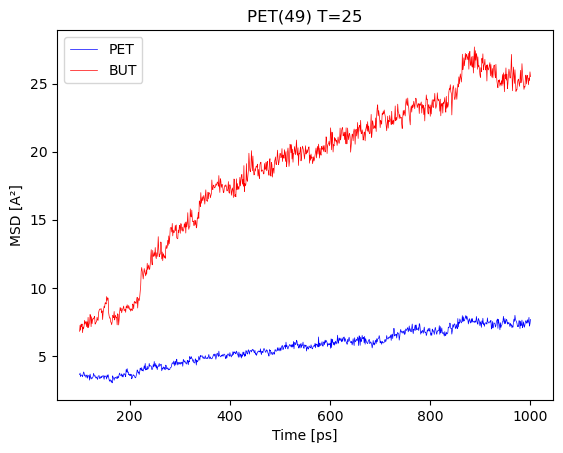

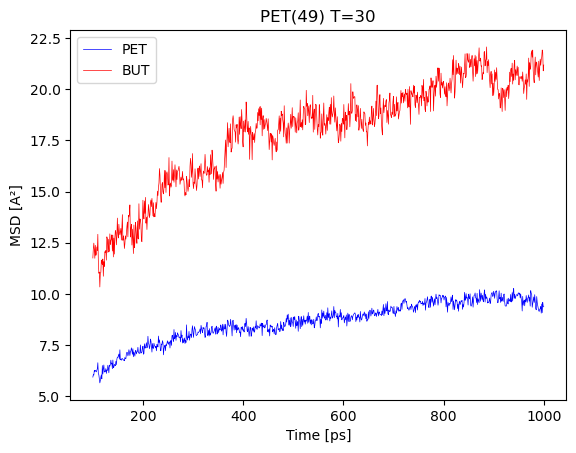

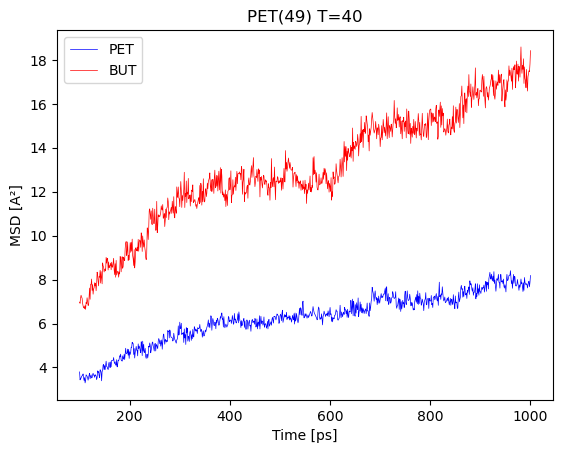

In [13]:
# MSE
color = 'black'
for mol in base.MolNames:
    for x in [i[0] for i in base.DATAS[mol]]:
        for T in [15, 20, 25, 30, 40]:
            df = DF[(DF['substance'] == mol.value) & (DF['x'] == x) & (DF['T'] == T)]
            if len(df) == 0:
                continue
            fig, ax = plt.subplots()

            ax.plot(
                df['Time'] * 10**12,
                df['MSD substance'] * 10**16,
                label=mol.value,
                linewidth=0.5,
                c='blue',
            )
            ax.plot(
                df['Time'] * 10**12,
                df['MSD butanol'] * 10**16,
                label='BUT',
                linewidth=0.5,
                c='red',
            )

            ax.set_title(f'{mol.value}({x}) {T=}')
            ax.set_xlabel('Time [ps]')
            ax.set_ylabel('MSD [A²]')
            ax.legend()
            plt.show()


In [7]:
DF_D = extract_D(DF)
DF_D

substance    x   T  D_substance  D_butanol
0        BUT  100  15     0.289796   0.289796
1        BUT  100  20     0.465019   0.465019
2        BUT  100  25     0.566347   0.566347
3        BUT  100  30     0.686457   0.686457
4        BUT  100  40     0.746760   0.746760
..       ...  ...  ..          ...        ...
86       PET   30  20     0.005769   0.006510
87       PET   30  25     0.004693   0.008029
88       PET   30  30     0.003073   0.013351
89       PET   30  40     0.005467   0.011967
90       PET   41  15     0.003725   0.010810

[91 rows x 5 columns]

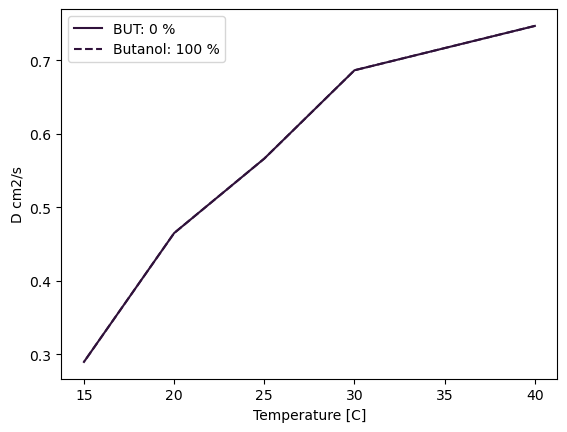

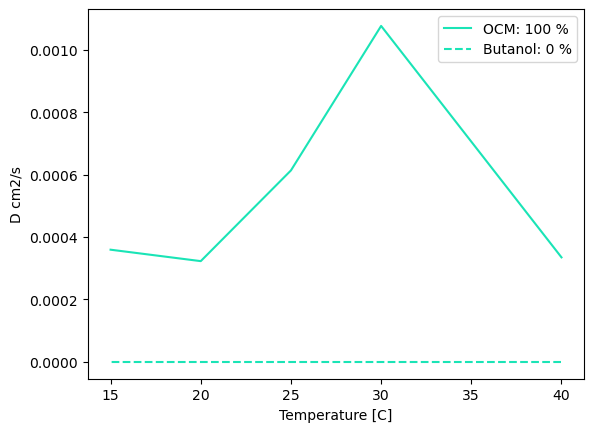

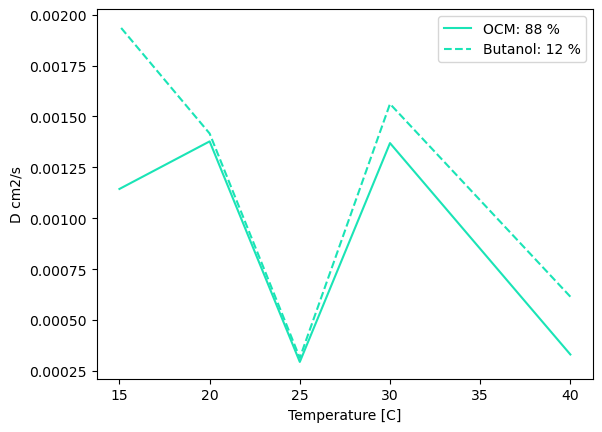

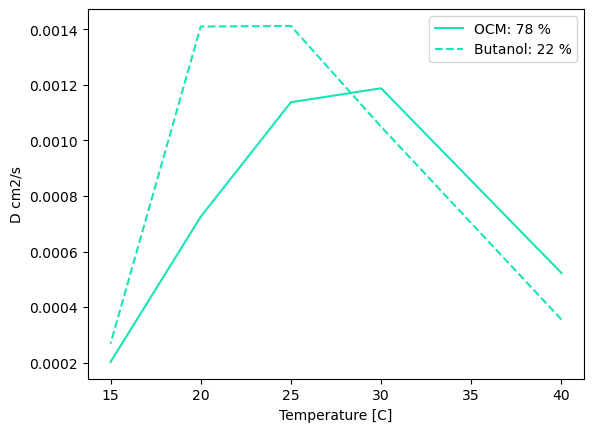

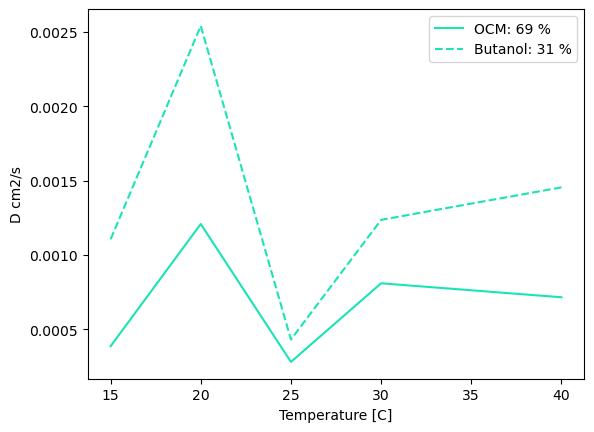

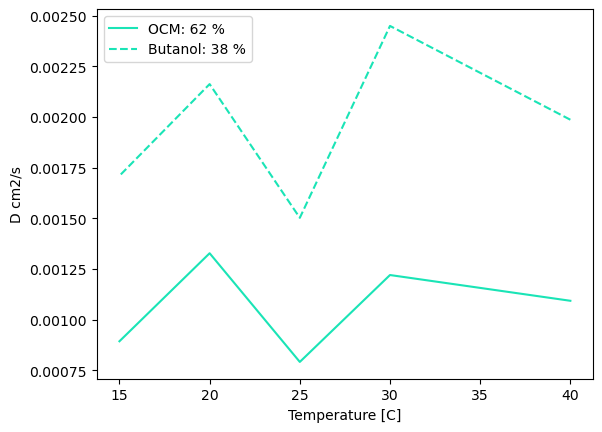

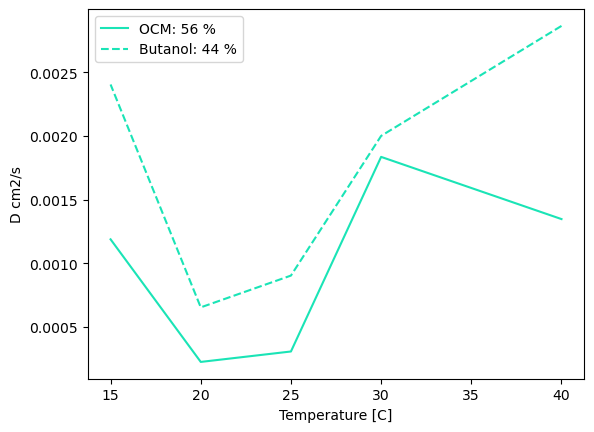

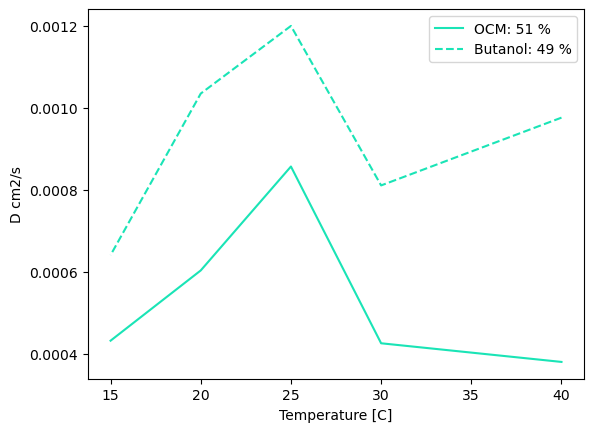

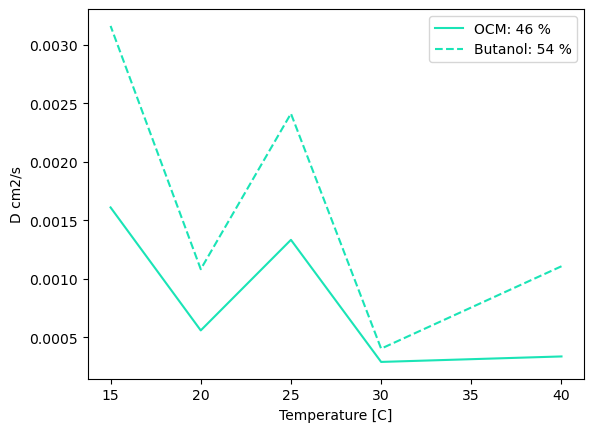

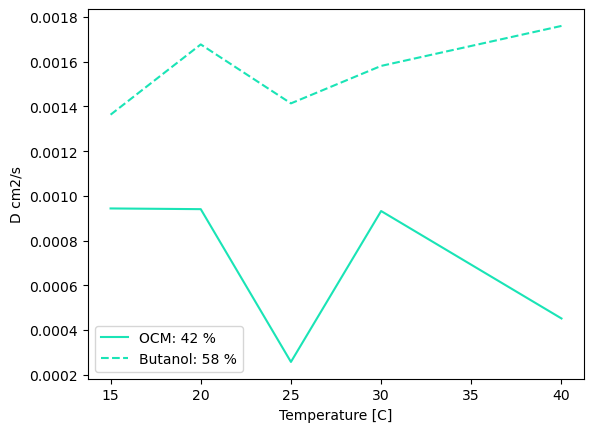

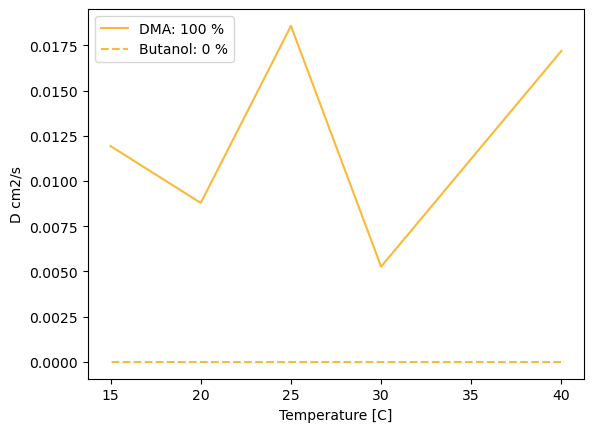

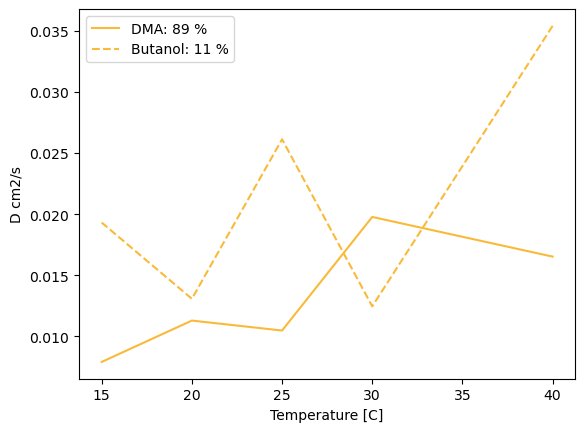

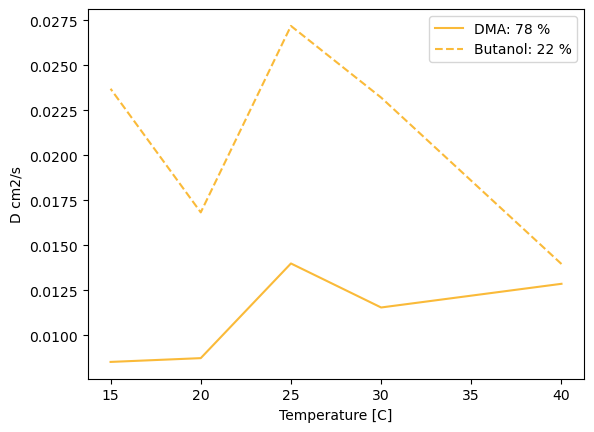

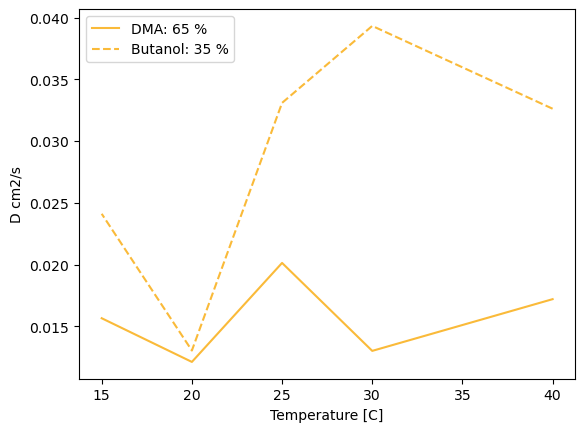

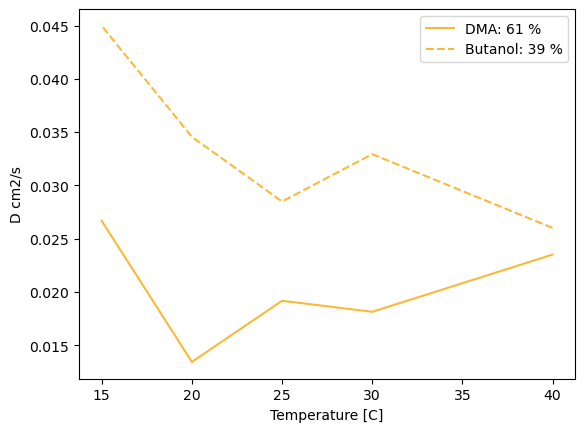

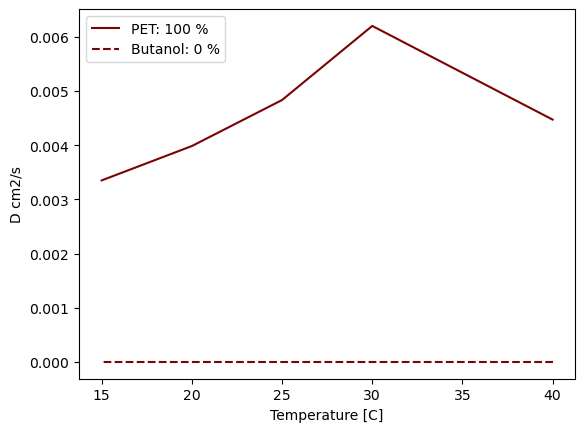

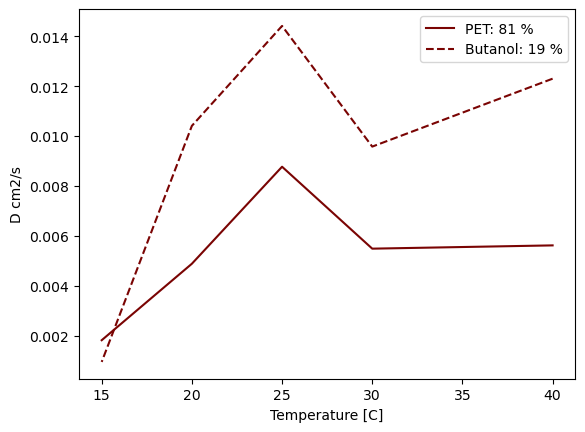

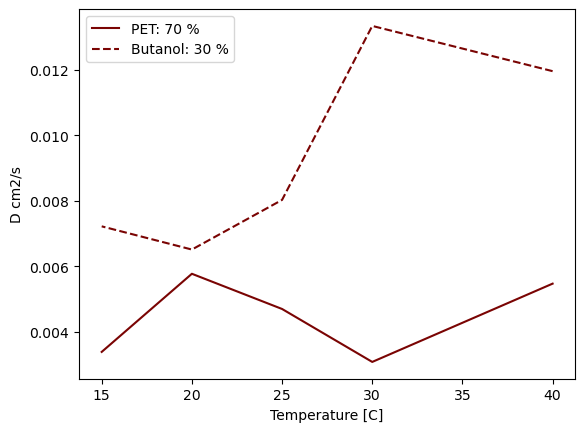

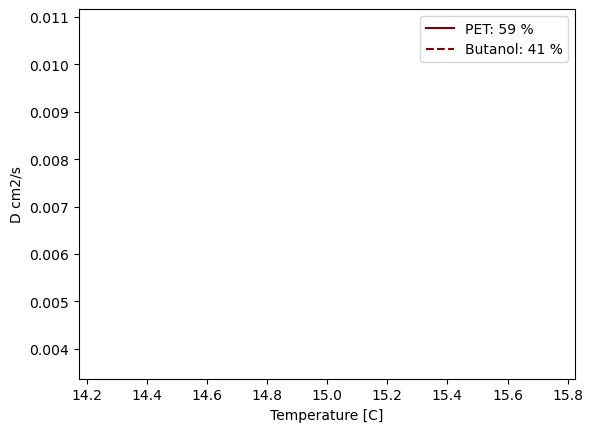

In [14]:
# D
colors_list = mcp.gen_color(
        cmap="turbo",
        n=len(DF_D['substance'].unique()),
    )
i = 0
for substance in base.MolNames:
    substance = substance.value
    df_sub = DF_D[DF_D['substance'] == substance]
    if len(df_sub) == 0:
        continue

    # fig, ax = plt.subplots(num="DT")

    for [x], df in df_sub.groupby(by=['x']):
        fig, ax = plt.subplots(num="DT")
        data_x = df.sort_values(by=['T'], ascending=False)
        ax.plot(
            data_x['T'],
            data_x['D_substance'],
            label=f"{substance}: {100-x} %",
            c=colors_list[i],
        )
        ax.plot(
            data_x['T'],
            data_x['D_butanol'],
            linestyle='dashed',
            label=f"Butanol: {x} %",
            c=colors_list[i],
        )

        ax.set_xlabel("Temperature [C]")
        ax.set_ylabel("D cm2/s")
        ax.legend()
        plt.show()
    i += 1